# 1. Developing and Saving the Dataset

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import os
import pandas as pd

In [18]:
PRECOMPUTED_DATA_ROOT = r"C:\Users\manav\KyodaiNaturalResourceLab\dataset"

class PrecomputedNoise2NoiseDataset(Dataset):
    def __init__(self, manifest_file, root_dir):
        self.root_dir = root_dir
        try:
            self.manifest = pd.read_csv(manifest_file)
        except FileNotFoundError:
            print(f"Error: Manifest file not found at {manifest_file}")
            print("Please ensure you have run the data generation phase first.")
            self.manifest = pd.DataFrame() # Empty dataframe

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        if idx >= len(self.manifest):
            raise IndexError("Index out of bounds")
            
        record = self.manifest.iloc[idx]
        
        noisy1_path = os.path.join(self.root_dir, record['noisy1_path'])
        noisy2_path = os.path.join(self.root_dir, record['noisy2_path'])
        clean_path = os.path.join(self.root_dir, record['clean_path'])

        # --- Metadata to return ---
        time_step = record['time_step']
        config_name = record['config_name']
        # --- End Metadata ---

        try:
            noisy1_tensor = torch.load(noisy1_path)
            noisy2_tensor = torch.load(noisy2_path)
            clean_tensor = torch.load(clean_path)
        except FileNotFoundError as e:
            print(f"Error loading file for sample id {record['id']}: {e}")
            dummy_tensor = torch.zeros((1, IMG_SIZE[0], IMG_SIZE[1]), dtype=torch.float)
            # Return dummy metadata as well, or handle appropriately
            return dummy_tensor, dummy_tensor, dummy_tensor, 0.0, "error_config" 
        except Exception as e:
            print(f"Generic error loading file for sample id {record['id']}: {e}")
            dummy_tensor = torch.zeros((1, IMG_SIZE[0], IMG_SIZE[1]), dtype=torch.float)
            return dummy_tensor, dummy_tensor, dummy_tensor, 0.0, "error_config"

        # Return tensors and the new metadata
        return noisy1_tensor, noisy2_tensor, clean_tensor, time_step, config_name

In [13]:
# --- Load manifest and create datasets/dataloaders for training ---
manifest_path = os.path.join(PRECOMPUTED_DATA_ROOT, 'manifest.csv')

# Check if manifest exists before proceeding
if not os.path.exists(manifest_path):
    print(f"Manifest file {manifest_path} not found. Please run the data generation phase first.")
    # You might want to exit or prevent further execution if manifest is missing
    # For now, this will lead to an empty dataset if PrecomputedNoise2NoiseDataset handles it.
    
full_dataset = PrecomputedNoise2NoiseDataset(manifest_file=manifest_path, root_dir=PRECOMPUTED_DATA_ROOT)

train_loader, val_loader, test_loader = None, None, None

if len(full_dataset) > 0:
    total_samples = len(full_dataset)
    indices = list(range(total_samples))
    np.random.shuffle(indices)

    train_ratio = 0.7
    val_ratio = 0.15
    # test_ratio = 0.15 implicitly

    if total_samples < 3:
        train_indices = indices
        val_indices, test_indices = [],[]
    else:
        train_split_idx = int(train_ratio * total_samples)
        val_split_idx = train_split_idx + int(val_ratio * total_samples)
        
        train_indices = indices[:train_split_idx]
        val_indices = indices[train_split_idx:val_split_idx]
        test_indices = indices[val_split_idx:]

        # Ensure all sets have at least one sample if total_samples allows
        if not test_indices and val_indices: test_indices = val_indices[-1:]; val_indices = val_indices[:-1]
        if not val_indices and train_indices: val_indices = train_indices[-1:]; train_indices = train_indices[:-1]


    train_subset = Subset(full_dataset, train_indices)
    val_subset = Subset(full_dataset, val_indices)
    test_subset = Subset(full_dataset, test_indices)

    print(f"Total precomputed samples: {total_samples}")
    print(f"Train samples: {len(train_subset)}")
    print(f"Validation samples: {len(val_subset)}")
    print(f"Test samples: {len(test_subset)}")
    
    BATCH_SIZE = 1 # Keep batch size small for 1500x1500 images
    if len(train_subset) > 0:
        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    if len(val_subset) > 0:
        val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
    if len(test_subset) > 0:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

else:
    print("Full dataset is empty. Cannot create data loaders.")

Total precomputed samples: 120
Train samples: 84
Validation samples: 18
Test samples: 18


In [14]:
# --- CNN Model (Simple U-Net like structure) ---
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128]): # Reduced features
        super(SimpleUNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        for feature in features:
            self.downs.append(self._double_conv(in_channels, feature))
            in_channels = feature
        self.bottleneck = self._double_conv(features[-1], features[-1] * 2)
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(self._double_conv(feature * 2, feature))
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def _double_conv(self, in_c, out_c):
        conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
        )
        return conv

    def forward(self, x):
        skip_connections = []
        for down_conv in self.downs:
            x = down_conv(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i//2]
            if x.shape != skip_connection.shape:
                x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[i+1](concat_skip)
        return self.final_conv(x)

Using device: cuda

Starting training...

--- Epoch 1/10 ---


C:\Users\manav\AppData\Local\Temp\ipykernel_15588\1176685887.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda')) # Mixed precision
C:\Users\manav\AppData\Local\Temp\ipykernel_15588\358810313.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_

Train Batch 0/84, Loss: 1.6073
Train Batch 10/84, Loss: 1.5231
Train Batch 20/84, Loss: 1.4456
Train Batch 30/84, Loss: 1.4927
Train Batch 40/84, Loss: 1.4180
Train Batch 50/84, Loss: 1.4138
Train Batch 60/84, Loss: 1.3745
Train Batch 70/84, Loss: 1.3228
Train Batch 80/84, Loss: 1.3485
End of Epoch, Avg Training Loss: 1.4506


C:\Users\manav\AppData\Local\Temp\ipykernel_15588\1176685887.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):


Validation Avg Loss: 1.3582
Saved new best model with val_loss: 1.3582 to best_denoising_model.pth

--- Epoch 2/10 ---
Train Batch 0/84, Loss: 1.2975
Train Batch 10/84, Loss: 1.2748
Train Batch 20/84, Loss: 1.2509
Train Batch 30/84, Loss: 1.3275
Train Batch 40/84, Loss: 1.4460
Train Batch 50/84, Loss: 1.3621
Train Batch 60/84, Loss: 1.3249
Train Batch 70/84, Loss: 1.3416
Train Batch 80/84, Loss: 1.2969
End of Epoch, Avg Training Loss: 1.3430
Validation Avg Loss: 1.3422
Saved new best model with val_loss: 1.3422 to best_denoising_model.pth

--- Epoch 3/10 ---
Train Batch 0/84, Loss: 1.3439
Train Batch 10/84, Loss: 1.3471
Train Batch 20/84, Loss: 1.3125
Train Batch 30/84, Loss: 1.3158
Train Batch 40/84, Loss: 1.3188
Train Batch 50/84, Loss: 1.4182
Train Batch 60/84, Loss: 1.3243
Train Batch 70/84, Loss: 1.3887
Train Batch 80/84, Loss: 1.3824
End of Epoch, Avg Training Loss: 1.3356
Validation Avg Loss: 1.3372
Saved new best model with val_loss: 1.3372 to best_denoising_model.pth

--- Epoc

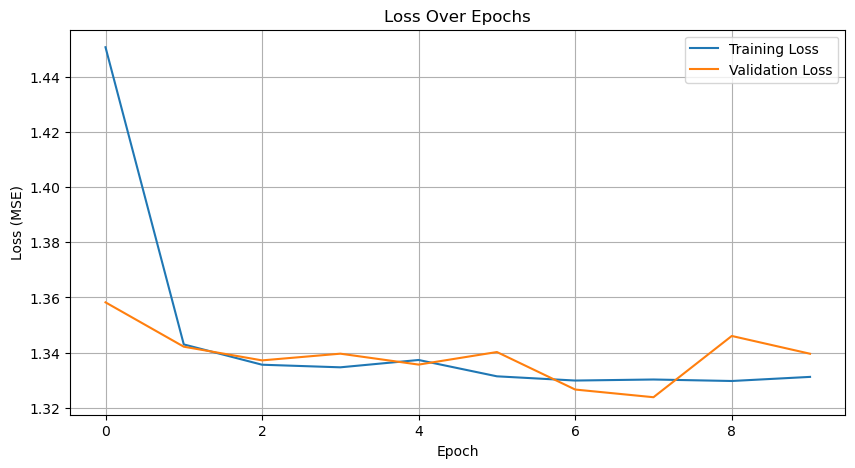

In [15]:
# --- Training Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

MODEL_FEATURES = [32, 64, 128] # Further reduced features for 1500x1500
model = SimpleUNet(in_channels=1, out_channels=1, features=MODEL_FEATURES).to(DEVICE)

LEARNING_RATE = 1e-4 
NUM_EPOCHS = 10 # Start with fewer epochs
WEIGHT_DECAY = 1e-5

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda')) # Mixed precision

# --- Training and Validation Loops (mostly unchanged) ---
def train_one_epoch(loader, model, optimizer, criterion, device, scaler):
    model.train()
    epoch_loss = 0
    if loader is None:
        print("Training loader is None, skipping training epoch.")
        return 0.0
    for batch_idx, (noisy1, noisy2, _) in enumerate(loader):
        noisy1, noisy2 = noisy1.to(device), noisy2.to(device)
        with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
            denoised_output = model(noisy1)
            loss = criterion(denoised_output, noisy2)
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        if batch_idx % 10 == 0: print(f"Train Batch {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}")
    if len(loader) == 0: return 0.0
    avg_epoch_loss = epoch_loss / len(loader)
    print(f"End of Epoch, Avg Training Loss: {avg_epoch_loss:.4f}")
    return avg_epoch_loss

def validate_one_epoch(loader, model, criterion, device):
    model.eval()
    epoch_loss = 0
    if loader is None:
        print("Validation loader is None, skipping validation epoch.")
        return float('inf')
    with torch.no_grad():
        for noisy1, noisy2, _ in loader:
            noisy1, noisy2 = noisy1.to(device), noisy2.to(device)
            with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
                denoised_output = model(noisy1)
                loss = criterion(denoised_output, noisy2)
            epoch_loss += loss.item()
    if len(loader) == 0: return float('inf')
    avg_epoch_loss = epoch_loss / len(loader)
    print(f"Validation Avg Loss: {avg_epoch_loss:.4f}")
    return avg_epoch_loss

print("\nStarting training...")
train_losses, val_losses = [], []
best_val_loss = float('inf')

if train_loader is not None:
    for epoch in range(NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        train_loss = train_one_epoch(train_loader, model, optimizer, criterion, DEVICE, scaler)
        train_losses.append(train_loss)
        val_loss = float('inf')
        if val_loader is not None:
            val_loss = validate_one_epoch(val_loader, model, criterion, DEVICE)
            val_losses.append(val_loss)
        
        save_path = f"model_epoch_{epoch+1}.pth"
        if val_loss < best_val_loss : # Condition met if val_loader exists and loss improved
            if val_loader is not None: # ensure val_loss is from actual validation
                 best_val_loss = val_loss
                 save_path = "best_denoising_model.pth"
                 print(f"Saved new best model with val_loss: {best_val_loss:.4f} to {save_path}")
        torch.save(model.state_dict(), save_path)
        if val_loader is None: print(f"Saved model checkpoint to {save_path} (no validation).")

else:
    print("Training cannot proceed as train_loader is not available.")

print("\nTraining finished!")

if train_losses or val_losses:
    plt.figure(figsize=(10,5))
    if train_losses: plt.plot(train_losses, label="Training Loss")
    if val_losses: plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss (MSE)"); plt.title("Loss Over Epochs")
    plt.legend(); plt.grid(True); plt.show()


Loading best validation model for display...

Displaying results from Test Set...


C:\Users\manav\AppData\Local\Temp\ipykernel_15588\2975567080.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_denoising_model.pth"

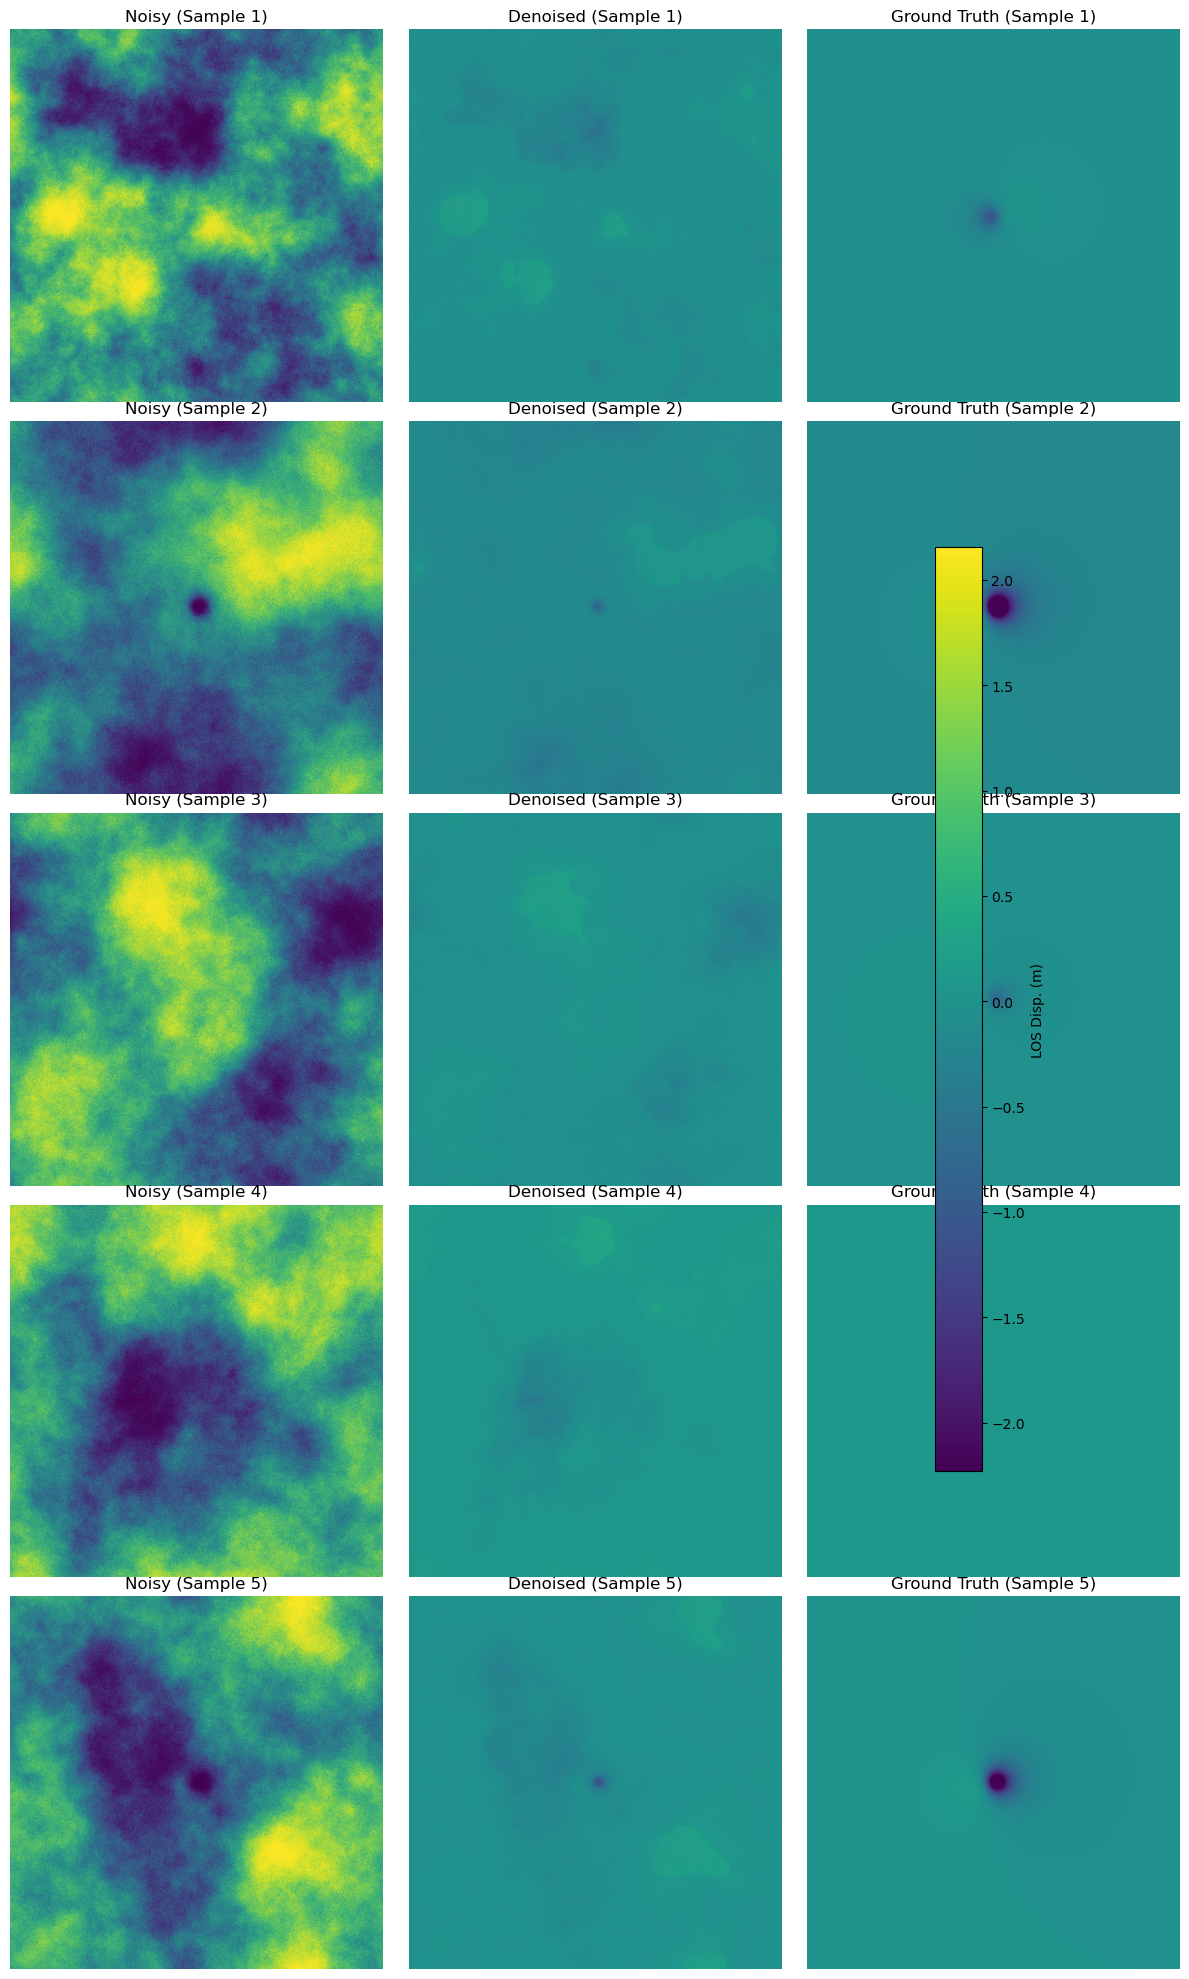

In [16]:
# (In the cell where display_results is defined)

def display_results(model, data_loader, device, num_samples=5): # Consider if 5 is too many for large images
    if data_loader is None or len(data_loader) == 0:
        print("Data loader for display is None or empty. Skipping display.")
        return
    model.eval().to(device)
    data_iter = iter(data_loader) # Create an iterator

    # Adjust num_samples if it's larger than the dataset
    if num_samples > len(data_loader.dataset): # Access full dataset length if it's a Subset
        print(f"Warning: num_samples ({num_samples}) is greater than dataset size ({len(data_loader.dataset)}).")
        print(f"Adjusting num_samples to {len(data_loader.dataset)}.")
        num_samples = len(data_loader.dataset)
    if num_samples == 0:
        print("No samples to display.")
        return

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4 * num_samples)) # Increased width slightly
    if num_samples == 1: 
        axes = np.array([axes]) # Ensure axes is always 2D for consistent indexing

    with torch.no_grad():
        for i in range(num_samples):
            try:
                # Unpack the new metadata
                noisy_input, _, ground_truth, time_steps, config_names = next(data_iter)
                
                # If batch size is 1 (as it is in your setup), time_steps and config_names
                # will be iterables of length 1. Extract the first element.
                time_step = time_steps[0] if isinstance(time_steps, (list, torch.Tensor)) else time_steps
                config_name = config_names[0] if isinstance(config_names, list) else config_names

            except StopIteration: 
                print("Not enough samples in the data_loader to display the requested num_samples.")
                break # Exit the loop if we run out of data

            noisy_input = noisy_input.to(device)
            single_noisy_input = noisy_input[0:1] # Keep batch dim
            single_ground_truth = ground_truth[0].cpu().numpy().squeeze()
            denoised_output = model(single_noisy_input)
            single_denoised_output = denoised_output[0].cpu().numpy().squeeze()
            single_noisy_input_np = single_noisy_input[0].cpu().numpy().squeeze()

            all_vals = np.concatenate([
                single_noisy_input_np.ravel(), single_denoised_output.ravel(), single_ground_truth.ravel()
            ])
            vmin = np.percentile(all_vals, 1) 
            vmax = np.percentile(all_vals, 99)
            if vmin >= vmax: vmin, vmax = all_vals.min(), all_vals.max() # Fallback
            if vmin == vmax: vmin -= 0.1; vmax += 0.1 # Ensure range for flat data
            
            # --- Updated titles ---
            base_title = f"(Sample {i+1}, Day {time_step}, {config_name})"
            axes[i,0].set_title(f"Noisy {base_title}")
            axes[i,0].axis('off')
            im = axes[i,0].imshow(single_noisy_input_np,cmap='viridis',vmin=vmin,vmax=vmax)
            
            axes[i,1].set_title(f"Denoised {base_title}")
            axes[i,1].axis('off')
            im_denoised = axes[i,1].imshow(single_denoised_output,cmap='viridis',vmin=vmin,vmax=vmax) # Use a different variable for the imshow return if needed for colorbar
            
            axes[i,2].set_title(f"Ground Truth {base_title}")
            axes[i,2].axis('off')
            im_gt = axes[i,2].imshow(single_ground_truth,cmap='viridis',vmin=vmin,vmax=vmax) # Use a different variable

    # Ensure colorbar uses a relevant 'im' (e.g., the last one from ground truth)
    if num_samples > 0 and 'im_gt' in locals(): # Check if im_gt was created
        fig.colorbar(im_gt, ax=axes.ravel().tolist(), shrink=0.6, label='LOS Disp. (m)')
    
    plt.tight_layout()
    plt.show()